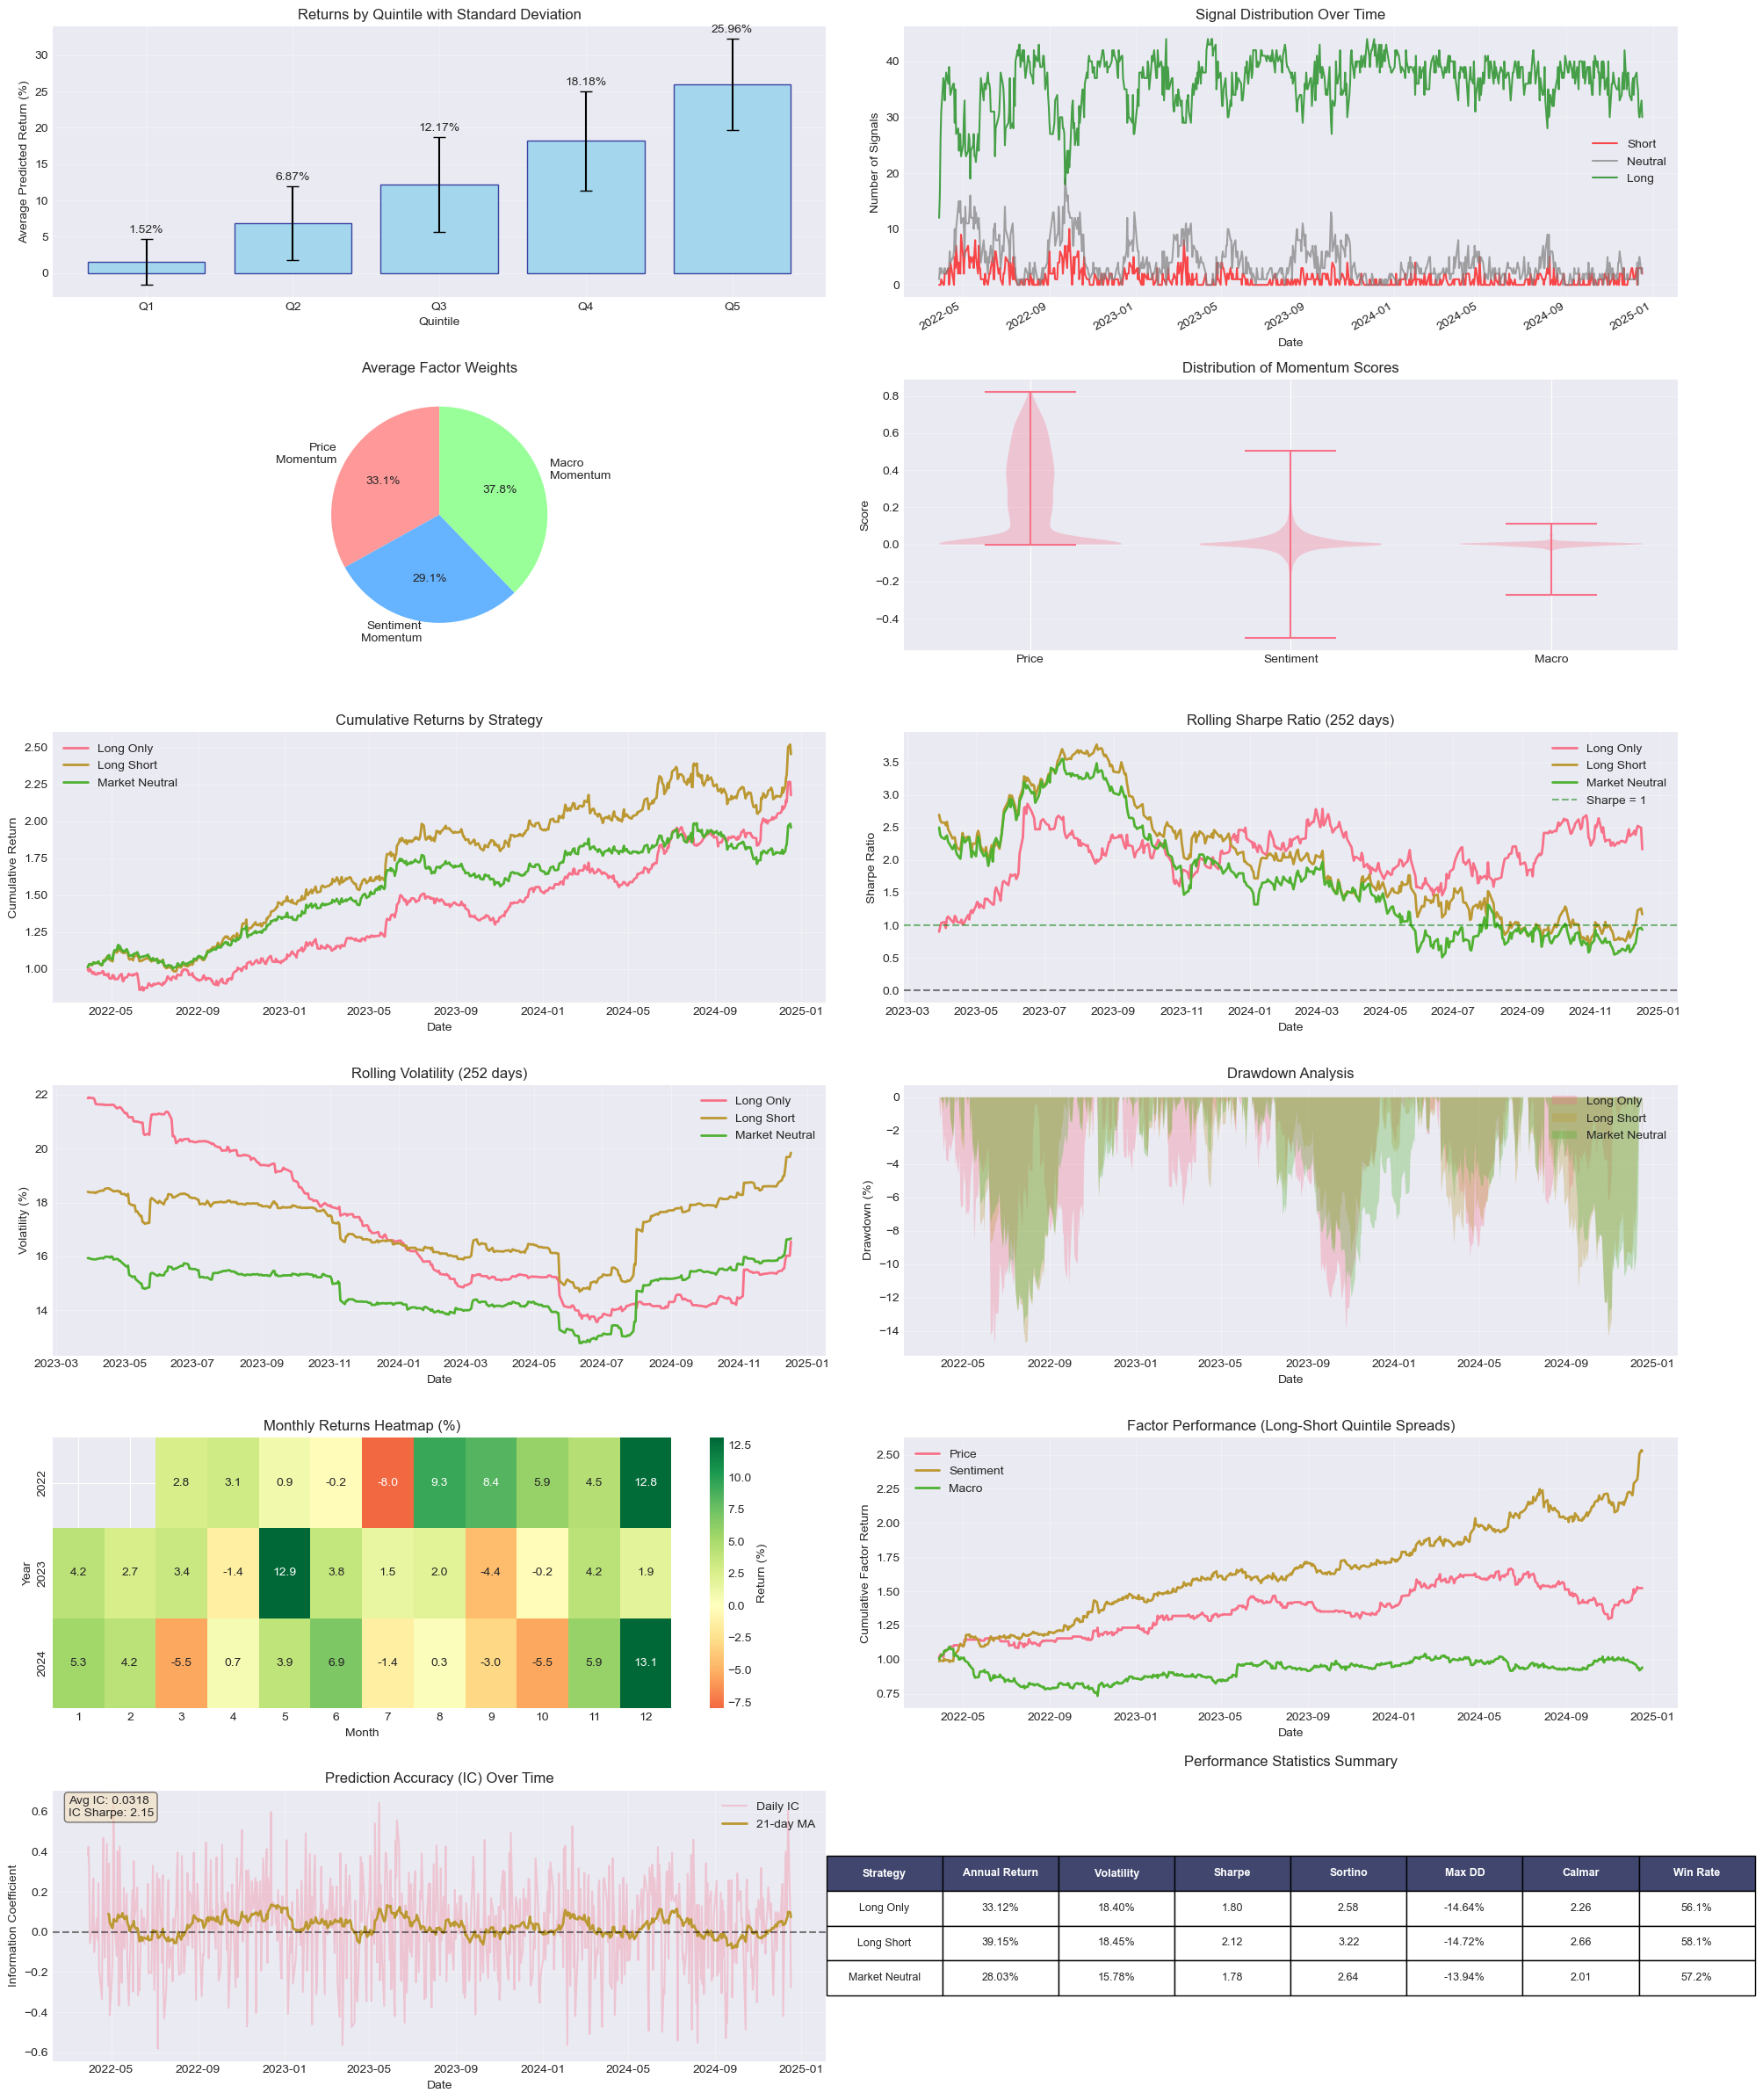


ALPHA PERFORMANCE STATISTICAL SUMMARY

1. SIGNAL QUALITY METRICS
----------------------------------------
Q5-Q1 Spread: 24.44%
Signal Consistency (lower is better): 0.411
Average Stocks per Day: 41.6

2. FACTOR ANALYSIS
----------------------------------------
Factor Coefficients:
  price_momentum_score: 0.001918
  sentiment_momentum_score: 0.004170
  macro_momentum_score: 0.002569
R-squared: 0.0008

3. PORTFOLIO PERFORMANCE SUMMARY
----------------------------------------

LONG ONLY:
  Total Return: 117.62%
  Annualized Return: 33.12%
  Annualized Volatility: 18.40%
  Sharpe Ratio: 1.80
  Best Month: 11.45%
  Worst Month: -7.11%
  % Positive Months: 55.9%

LONG SHORT:
  Total Return: 145.48%
  Annualized Return: 39.15%
  Annualized Volatility: 18.45%
  Sharpe Ratio: 2.12
  Best Month: 13.08%
  Worst Month: -7.98%
  % Positive Months: 73.5%

MARKET NEUTRAL:
  Total Return: 95.75%
  Annualized Return: 28.03%
  Annualized Volatility: 15.78%
  Sharpe Ratio: 1.78
  Best Month: 13.36%
  Wo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class AlphaPerformanceAnalyzer:
    """
    Comprehensive Alpha Performance Analysis Tool
    """
    
    def __init__(self, alpha_signals_path, price_data_path=None):
        """
        Initialize the analyzer with data paths
        
        Parameters:
        -----------
        alpha_signals_path : str
            Path to the alpha signals CSV file
        price_data_path : str, optional
            Path to the OHLCV price data CSV file
        """
        self.alpha_signals = pd.read_csv(alpha_signals_path)
        self.alpha_signals['date'] = pd.to_datetime(self.alpha_signals['date'])
        
        if price_data_path:
            self.price_data = pd.read_csv(price_data_path)
            self.price_data['Date'] = pd.to_datetime(self.price_data['Date'])
            self.has_price_data = True
        else:
            self.has_price_data = False
            
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare and clean the data for analysis"""
        # Sort by date and ticker
        self.alpha_signals = self.alpha_signals.sort_values(['date', 'ticker'])
        
        # Create additional features
        self.alpha_signals['year'] = self.alpha_signals['date'].dt.year
        self.alpha_signals['month'] = self.alpha_signals['date'].dt.to_period('M')
        self.alpha_signals['quarter'] = self.alpha_signals['date'].dt.to_period('Q')
        
    def calculate_realized_returns(self):
        """Calculate realized returns if price data is available"""
        if not self.has_price_data:
            print("Price data not available. Using predicted returns for analysis.")
            return
        
        # Merge alpha signals with price data
        self.price_data['next_day_return'] = (
            self.price_data.groupby('Ticker')['Close']
            .pct_change()
            .shift(-1)
        )
        
        # Merge on date and ticker
        self.alpha_signals = pd.merge(
            self.alpha_signals,
            self.price_data[['Date', 'Ticker', 'next_day_return']],
            left_on=['date', 'ticker'],
            right_on=['Date', 'Ticker'],
            how='left'
        )
        
        self.alpha_signals['realized_return'] = self.alpha_signals['next_day_return']
        
    def calculate_portfolio_returns(self, weighting='equal', rebalance='daily'):
        """
        Calculate portfolio returns based on signals
        
        Parameters:
        -----------
        weighting : str
            'equal' or 'signal_weighted'
        rebalance : str
            'daily', 'weekly', or 'monthly'
            
        Strategy Definitions:
        -------------------
        1. Long-only: Buy stocks in the top quintile (Q5)
        2. Long-short: Buy Q5 stocks, sell Q1 stocks
        3. Market-neutral: Buy top 30% of stocks, sell bottom 30% with equal dollar amounts
        """
        results = {}
        
        # Long-only portfolio (Q5)
        q5_signals = self.alpha_signals[self.alpha_signals['quintile'] == 'Q5'].copy()
        results['long_only'] = self._calculate_portfolio_metrics(q5_signals, weighting)
        
        # Long-short portfolio (Long Q5, Short Q1)
        q1_signals = self.alpha_signals[self.alpha_signals['quintile'] == 'Q1'].copy()
        results['long_short'] = self._calculate_ls_portfolio_metrics(q5_signals, q1_signals, weighting)
        
        # Market-neutral portfolio
        results['market_neutral'] = self._calculate_mn_portfolio_metrics(self.alpha_signals, weighting)
        
        return results
        
    def _calculate_portfolio_metrics(self, signals, weighting='equal'):
        """Calculate portfolio metrics for a given set of signals"""
        # Group by date
        daily_returns = []
        
        if self.has_price_data and 'realized_return' in signals.columns:
            return_col = 'realized_return'
        else:
            return_col = 'predicted_return'
            
        for date, group in signals.groupby('date'):
            if weighting == 'equal':
                daily_ret = group[return_col].mean()
            else:  # signal_weighted
                weights = group['signal_strength'] / group['signal_strength'].sum()
                daily_ret = (group[return_col] * weights).sum()
            
            daily_returns.append({
                'date': date,
                'return': daily_ret,
                'n_positions': len(group)
            })
            
        portfolio_df = pd.DataFrame(daily_returns)
        portfolio_df = portfolio_df.set_index('date').sort_index()
        
        return portfolio_df
        
    def _calculate_ls_portfolio_metrics(self, long_signals, short_signals, weighting='equal'):
        """Calculate long-short portfolio metrics"""
        long_portfolio = self._calculate_portfolio_metrics(long_signals, weighting)
        short_portfolio = self._calculate_portfolio_metrics(short_signals, weighting)
        
        # Combine long and short
        ls_portfolio = pd.merge(
            long_portfolio, 
            short_portfolio, 
            left_index=True, 
            right_index=True, 
            suffixes=('_long', '_short'),
            how='outer'
        ).fillna(0)
        
        ls_portfolio['return'] = ls_portfolio['return_long'] - ls_portfolio['return_short']
        ls_portfolio['n_positions'] = ls_portfolio['n_positions_long'] + ls_portfolio['n_positions_short']
        
        return ls_portfolio[['return', 'n_positions']]
        
    def _calculate_mn_portfolio_metrics(self, signals, weighting='equal'):
        """Calculate market-neutral portfolio metrics"""
        portfolio_returns = []
        
        if self.has_price_data and 'realized_return' in signals.columns:
            return_col = 'realized_return'
        else:
            return_col = 'predicted_return'
            
        for date, group in signals.groupby('date'):
            # Sort by predicted returns and create long/short portfolios
            sorted_group = group.sort_values('predicted_return', ascending=False)
            n_stocks = len(sorted_group)
            
            if n_stocks >= 10:  # Need enough stocks for a balanced portfolio
                # Take top 30% as long, bottom 30% as short
                n_long = max(1, int(n_stocks * 0.3))
                n_short = max(1, int(n_stocks * 0.3))
                
                long_positions = sorted_group.head(n_long)
                short_positions = sorted_group.tail(n_short)
                
                if weighting == 'equal':
                    # Equal weight within long and short portfolios
                    long_ret = long_positions[return_col].mean()
                    short_ret = short_positions[return_col].mean()
                else:
                    # Signal-weighted
                    long_weights = long_positions['signal_strength'] / long_positions['signal_strength'].sum()
                    short_weights = short_positions['signal_strength'] / short_positions['signal_strength'].sum()
                    long_ret = (long_positions[return_col] * long_weights).sum()
                    short_ret = (short_positions[return_col] * short_weights).sum()
                
                # Market neutral: equal dollar long and short
                daily_ret = long_ret - short_ret
                n_positions = n_long + n_short
            else:
                daily_ret = 0
                n_positions = 0
                
            portfolio_returns.append({
                'date': date,
                'return': daily_ret,
                'n_positions': n_positions
            })
            
        return pd.DataFrame(portfolio_returns).set_index('date').sort_index()
        
    def calculate_rolling_metrics(self, portfolio_returns, window=252):
        """
        Calculate rolling performance metrics
        
        Parameters:
        -----------
        portfolio_returns : pd.DataFrame
            DataFrame with 'return' column
        window : int
            Rolling window size (default 252 for 1 year)
        """
        metrics = pd.DataFrame(index=portfolio_returns.index)
        
        # Rolling returns
        metrics['rolling_return'] = portfolio_returns['return'].rolling(window).mean() * 252
        
        # Rolling volatility
        metrics['rolling_volatility'] = portfolio_returns['return'].rolling(window).std() * np.sqrt(252)
        
        # Rolling Sharpe ratio (assuming 0 risk-free rate)
        metrics['rolling_sharpe'] = metrics['rolling_return'] / metrics['rolling_volatility']
        
        # Rolling maximum drawdown
        cumulative_returns = (1 + portfolio_returns['return']).cumprod()
        rolling_max = cumulative_returns.rolling(window, min_periods=1).max()
        metrics['rolling_drawdown'] = (cumulative_returns - rolling_max) / rolling_max
        
        # Rolling Sortino ratio
        downside_returns = portfolio_returns['return'].copy()
        downside_returns[downside_returns > 0] = 0
        downside_vol = downside_returns.rolling(window).std() * np.sqrt(252)
        metrics['rolling_sortino'] = metrics['rolling_return'] / downside_vol
        
        # Rolling Calmar ratio
        rolling_max_dd = metrics['rolling_drawdown'].rolling(window).min().abs()
        metrics['rolling_calmar'] = metrics['rolling_return'] / rolling_max_dd
        
        return metrics
        
    def calculate_factor_attribution(self):
        """Calculate performance attribution by factor"""
        attribution = {}
        
        # Group by quintile and calculate average factor scores
        factor_cols = ['price_momentum_score', 'sentiment_momentum_score', 'macro_momentum_score']
        
        quintile_factors = self.alpha_signals.groupby('quintile')[factor_cols].mean()
        attribution['quintile_factors'] = quintile_factors
        
        # Calculate factor contribution to returns
        if self.has_price_data and 'realized_return' in self.alpha_signals.columns:
            return_col = 'realized_return'
        else:
            return_col = 'predicted_return'
            
        # Regression analysis
        from sklearn.linear_model import LinearRegression
        
        X = self.alpha_signals[factor_cols].fillna(0)
        y = self.alpha_signals[return_col].fillna(0)
        
        model = LinearRegression()
        model.fit(X, y)
        
        attribution['factor_coefficients'] = pd.Series(model.coef_, index=factor_cols)
        attribution['r_squared'] = model.score(X, y)
        
        # Calculate factor returns over time
        factor_returns = {}
        for factor in factor_cols:
            factor_portfolio = self.alpha_signals.copy()
            factor_portfolio['factor_rank'] = factor_portfolio.groupby('date')[factor].rank(pct=True)
            top_quintile = factor_portfolio[factor_portfolio['factor_rank'] > 0.8]
            bottom_quintile = factor_portfolio[factor_portfolio['factor_rank'] < 0.2]
            
            top_returns = top_quintile.groupby('date')[return_col].mean()
            bottom_returns = bottom_quintile.groupby('date')[return_col].mean()
            
            factor_returns[factor] = (top_returns - bottom_returns).fillna(0)
            
        attribution['factor_returns'] = pd.DataFrame(factor_returns)
        
        return attribution
        
    def generate_performance_report(self, save_path='alpha_performance_report.html'):
        """Generate comprehensive performance report with visualizations"""
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 24))
        
        # 1. Quintile Analysis
        ax1 = plt.subplot(6, 2, 1)
        self.plot_quintile_returns(ax1)
        
        # 2. Signal Distribution
        ax2 = plt.subplot(6, 2, 2)
        self.plot_signal_distribution(ax2)
        
        # 3. Factor Weights
        ax3 = plt.subplot(6, 2, 3)
        self.plot_factor_weights(ax3)
        
        # 4. Momentum Score Distributions
        ax4 = plt.subplot(6, 2, 4)
        self.plot_momentum_distributions(ax4)
        
        # Calculate portfolio returns
        portfolios = self.calculate_portfolio_returns()
        
        # 5. Cumulative Returns
        ax5 = plt.subplot(6, 2, 5)
        self.plot_cumulative_returns(ax5, portfolios)
        
        # 6. Rolling Sharpe Ratios
        ax6 = plt.subplot(6, 2, 6)
        self.plot_rolling_sharpe(ax6, portfolios)
        
        # 7. Rolling Volatility
        ax7 = plt.subplot(6, 2, 7)
        self.plot_rolling_volatility(ax7, portfolios)
        
        # 8. Drawdown Analysis
        ax8 = plt.subplot(6, 2, 8)
        self.plot_drawdown_analysis(ax8, portfolios)
        
        # 9. Monthly Returns Heatmap
        ax9 = plt.subplot(6, 2, 9)
        self.plot_monthly_returns_heatmap(ax9, portfolios['long_short'])
        
        # 10. Factor Attribution
        ax10 = plt.subplot(6, 2, 10)
        attribution = self.calculate_factor_attribution()
        self.plot_factor_attribution(ax10, attribution)
        
        # 11. IC Analysis
        ax11 = plt.subplot(6, 2, 11)
        self.plot_ic_analysis(ax11)
        
        # 12. Performance Statistics Table
        ax12 = plt.subplot(6, 2, 12)
        self.plot_performance_table(ax12, portfolios)
        
        plt.tight_layout()
        plt.savefig(save_path.replace('.html', '.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Generate statistical summary
        self.generate_statistical_summary(portfolios, attribution)
        
    def plot_quintile_returns(self, ax):
        """Plot average returns by quintile"""
        quintile_returns = self.alpha_signals.groupby('quintile')['predicted_return'].agg(['mean', 'std', 'count'])
        
        quintiles = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
        means = [quintile_returns.loc[q, 'mean'] * 100 for q in quintiles]
        stds = [quintile_returns.loc[q, 'std'] * 100 for q in quintiles]
        
        x = np.arange(len(quintiles))
        ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
        ax.set_xlabel('Quintile')
        ax.set_ylabel('Average Predicted Return (%)')
        ax.set_title('Returns by Quintile with Standard Deviation')
        ax.set_xticks(x)
        ax.set_xticklabels(quintiles)
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + stds[i] + 0.5, f'{v:.2f}%', ha='center', va='bottom')
            
    def plot_signal_distribution(self, ax):
        """Plot distribution of signals over time"""
        signal_counts = self.alpha_signals.groupby(['date', 'signal']).size().unstack(fill_value=0)
        
        if -1 in signal_counts.columns:
            signal_counts[-1].plot(ax=ax, label='Short', color='red', alpha=0.7)
        if 0 in signal_counts.columns:
            signal_counts[0].plot(ax=ax, label='Neutral', color='gray', alpha=0.7)
        if 1 in signal_counts.columns:
            signal_counts[1].plot(ax=ax, label='Long', color='green', alpha=0.7)
            
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Signals')
        ax.set_title('Signal Distribution Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    def plot_factor_weights(self, ax):
        """Plot average factor weights"""
        weights = self.alpha_signals[['price_momentum_weight', 'sentiment_momentum_weight', 'macro_momentum_weight']].mean()
        
        labels = ['Price\nMomentum', 'Sentiment\nMomentum', 'Macro\nMomentum']
        sizes = weights.values * 100
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        
        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax.set_title('Average Factor Weights')
        
    def plot_momentum_distributions(self, ax):
        """Plot distributions of momentum scores"""
        momentum_cols = ['price_momentum_score', 'sentiment_momentum_score', 'macro_momentum_score']
        
        data_to_plot = []
        labels = []
        for col in momentum_cols:
            data = self.alpha_signals[col].dropna()
            data_to_plot.append(data)
            labels.append(col.replace('_momentum_score', '').capitalize())
            
        ax.violinplot(data_to_plot, positions=range(len(labels)), widths=0.7)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_ylabel('Score')
        ax.set_title('Distribution of Momentum Scores')
        ax.grid(True, alpha=0.3, axis='y')
        
    def plot_cumulative_returns(self, ax, portfolios):
        """Plot cumulative returns for different portfolio strategies"""
        for name, portfolio in portfolios.items():
            cumulative = (1 + portfolio['return']).cumprod()
            ax.plot(cumulative.index, cumulative.values, label=name.replace('_', ' ').title(), linewidth=2)
            
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Return')
        ax.set_title('Cumulative Returns by Strategy')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    def plot_rolling_sharpe(self, ax, portfolios, window=252):
        """Plot rolling Sharpe ratios"""
        for name, portfolio in portfolios.items():
            metrics = self.calculate_rolling_metrics(portfolio, window)
            ax.plot(metrics.index, metrics['rolling_sharpe'], label=name.replace('_', ' ').title(), linewidth=2)
            
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_title(f'Rolling Sharpe Ratio ({window} days)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    def plot_rolling_volatility(self, ax, portfolios, window=252):
        """Plot rolling volatility"""
        for name, portfolio in portfolios.items():
            metrics = self.calculate_rolling_metrics(portfolio, window)
            ax.plot(metrics.index, metrics['rolling_volatility'] * 100, 
                   label=name.replace('_', ' ').title(), linewidth=2)
            
        ax.set_xlabel('Date')
        ax.set_ylabel('Volatility (%)')
        ax.set_title(f'Rolling Volatility ({window} days)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    def plot_drawdown_analysis(self, ax, portfolios):
        """Plot drawdown analysis"""
        for name, portfolio in portfolios.items():
            cumulative = (1 + portfolio['return']).cumprod()
            running_max = cumulative.expanding().max()
            drawdown = (cumulative - running_max) / running_max * 100
            
            ax.fill_between(drawdown.index, drawdown.values, 0, 
                           alpha=0.3, label=name.replace('_', ' ').title())
            
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown (%)')
        ax.set_title('Drawdown Analysis')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    def plot_monthly_returns_heatmap(self, ax, portfolio):
        """Plot monthly returns heatmap"""
        monthly_returns = portfolio['return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
        
        # Create pivot table for heatmap
        monthly_returns_df = pd.DataFrame(monthly_returns)
        monthly_returns_df['Year'] = monthly_returns_df.index.year
        monthly_returns_df['Month'] = monthly_returns_df.index.month
        
        pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='return')
        
        # Plot heatmap
        sns.heatmap(pivot_table * 100, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                   cbar_kws={'label': 'Return (%)'}, ax=ax)
        ax.set_title('Monthly Returns Heatmap (%)')
        ax.set_xlabel('Month')
        ax.set_ylabel('Year')
        
    def plot_factor_attribution(self, ax, attribution):
        """Plot factor attribution analysis"""
        factor_returns = attribution['factor_returns']
        cumulative_factor_returns = (1 + factor_returns).cumprod()
        
        for col in cumulative_factor_returns.columns:
            label = col.replace('_momentum_score', '').capitalize()
            ax.plot(cumulative_factor_returns.index, cumulative_factor_returns[col], 
                   label=label, linewidth=2)
            
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Factor Return')
        ax.set_title('Factor Performance (Long-Short Quintile Spreads)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    def plot_ic_analysis(self, ax):
        """Plot Information Coefficient analysis"""
        # Calculate IC if we have realized returns
        if self.has_price_data and 'realized_return' in self.alpha_signals.columns:
            # Calculate daily IC
            daily_ic = self.alpha_signals.groupby('date').apply(
                lambda x: x['predicted_return'].corr(x['realized_return']) 
                if len(x) > 5 else np.nan
            )
            
            # Plot rolling IC
            rolling_ic = daily_ic.rolling(window=21).mean()  # 21-day rolling average
            
            ax.plot(daily_ic.index, daily_ic.values, alpha=0.3, label='Daily IC')
            ax.plot(rolling_ic.index, rolling_ic.values, linewidth=2, label='21-day MA')
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            
            ax.set_xlabel('Date')
            ax.set_ylabel('Information Coefficient')
            ax.set_title('Prediction Accuracy (IC) Over Time')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add statistics
            avg_ic = daily_ic.mean()
            ic_sharpe = daily_ic.mean() / daily_ic.std() * np.sqrt(252)
            ax.text(0.02, 0.98, f'Avg IC: {avg_ic:.4f}\nIC Sharpe: {ic_sharpe:.2f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            ax.text(0.5, 0.5, 'IC Analysis requires realized returns data', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Information Coefficient Analysis')
            
    def plot_performance_table(self, ax, portfolios):
        """Create performance statistics table"""
        ax.axis('tight')
        ax.axis('off')
        
        # Calculate statistics for each portfolio
        stats_data = []
        
        for name, portfolio in portfolios.items():
            returns = portfolio['return']
            
            # Annual return
            total_days = len(returns)
            total_return = (1 + returns).prod() - 1
            annual_return = (1 + total_return) ** (252 / total_days) - 1
            
            # Volatility
            volatility = returns.std() * np.sqrt(252)
            
            # Sharpe ratio
            sharpe = annual_return / volatility if volatility > 0 else 0
            
            # Maximum drawdown
            cumulative = (1 + returns).cumprod()
            running_max = cumulative.expanding().max()
            drawdown = ((cumulative - running_max) / running_max).min()
            
            # Sortino ratio
            downside_returns = returns[returns < 0]
            downside_vol = downside_returns.std() * np.sqrt(252)
            sortino = annual_return / downside_vol if downside_vol > 0 else 0
            
            # Calmar ratio
            calmar = annual_return / abs(drawdown) if drawdown != 0 else 0
            
            # Win rate
            win_rate = (returns > 0).mean()
            
            stats_data.append([
                name.replace('_', ' ').title(),
                f"{annual_return*100:.2f}%",
                f"{volatility*100:.2f}%",
                f"{sharpe:.2f}",
                f"{sortino:.2f}",
                f"{drawdown*100:.2f}%",
                f"{calmar:.2f}",
                f"{win_rate*100:.1f}%"
            ])
            
        columns = ['Strategy', 'Annual Return', 'Volatility', 'Sharpe', 'Sortino', 
                  'Max DD', 'Calmar', 'Win Rate']
        
        table = ax.table(cellText=stats_data, colLabels=columns, 
                        cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.8)
        
        # Color code the header
        for i in range(len(columns)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
            
        ax.set_title('Performance Statistics Summary', pad=20)
        
    def generate_statistical_summary(self, portfolios, attribution):
        """Generate detailed statistical summary"""
        print("\n" + "="*80)
        print("ALPHA PERFORMANCE STATISTICAL SUMMARY")
        print("="*80)
        
        # 1. Signal Quality Metrics
        print("\n1. SIGNAL QUALITY METRICS")
        print("-"*40)
        
        # Quintile spreads
        quintile_returns = self.alpha_signals.groupby('quintile')['predicted_return'].mean()
        q5_q1_spread = (quintile_returns['Q5'] - quintile_returns['Q1']) * 100
        print(f"Q5-Q1 Spread: {q5_q1_spread:.2f}%")
        
        # Signal consistency
        signal_consistency = self.alpha_signals.groupby('ticker')['signal'].std().mean()
        print(f"Signal Consistency (lower is better): {signal_consistency:.3f}")
        
        # Coverage
        avg_stocks_per_day = self.alpha_signals.groupby('date')['ticker'].count().mean()
        print(f"Average Stocks per Day: {avg_stocks_per_day:.1f}")
        
        # 2. Factor Analysis
        print("\n2. FACTOR ANALYSIS")
        print("-"*40)
        print("Factor Coefficients:")
        for factor, coef in attribution['factor_coefficients'].items():
            print(f"  {factor}: {coef:.6f}")
        print(f"R-squared: {attribution['r_squared']:.4f}")
        
        # 3. Portfolio Performance
        print("\n3. PORTFOLIO PERFORMANCE SUMMARY")
        print("-"*40)
        
        for name, portfolio in portfolios.items():
            print(f"\n{name.upper().replace('_', ' ')}:")
            returns = portfolio['return']
            
            # Calculate metrics
            total_return = (1 + returns).prod() - 1
            annual_return = (1 + total_return) ** (252 / len(returns)) - 1
            volatility = returns.std() * np.sqrt(252)
            sharpe = annual_return / volatility
            
            # Monthly statistics
            monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
            best_month = monthly_returns.max()
            worst_month = monthly_returns.min()
            positive_months = (monthly_returns > 0).mean()
            
            print(f"  Total Return: {total_return*100:.2f}%")
            print(f"  Annualized Return: {annual_return*100:.2f}%")
            print(f"  Annualized Volatility: {volatility*100:.2f}%")
            print(f"  Sharpe Ratio: {sharpe:.2f}")
            print(f"  Best Month: {best_month*100:.2f}%")
            print(f"  Worst Month: {worst_month*100:.2f}%")
            print(f"  % Positive Months: {positive_months*100:.1f}%")
            
        # 4. Risk Analysis
        print("\n4. RISK ANALYSIS")
        print("-"*40)
        
        # Correlation between strategies
        returns_df = pd.DataFrame({
            name: portfolio['return'] 
            for name, portfolio in portfolios.items()
        })
        
        print("\nStrategy Correlations:")
        print(returns_df.corr().round(3))
        
        # Tail risk analysis
        print("\nTail Risk Analysis (Long-Short Portfolio):")
        ls_returns = portfolios['long_short']['return']
        var_95 = ls_returns.quantile(0.05)
        var_99 = ls_returns.quantile(0.01)
        cvar_95 = ls_returns[ls_returns <= var_95].mean()
        cvar_99 = ls_returns[ls_returns <= var_99].mean()
        
        print(f"  VaR (95%): {var_95*100:.2f}%")
        print(f"  VaR (99%): {var_99*100:.2f}%")
        print(f"  CVaR (95%): {cvar_95*100:.2f}%")
        print(f"  CVaR (99%): {cvar_99*100:.2f}%")
        
        # Skewness and kurtosis
        skew = stats.skew(ls_returns.dropna())
        kurt = stats.kurtosis(ls_returns.dropna())
        print(f"  Skewness: {skew:.3f}")
        print(f"  Kurtosis: {kurt:.3f}")
        
        # 5. Stability Analysis
        print("\n5. STABILITY ANALYSIS")
        print("-"*40)
        
        # Rolling window analysis
        window_sizes = [63, 126, 252]  # 3m, 6m, 1y
        ls_portfolio = portfolios['long_short']
        
        for window in window_sizes:
            if len(ls_portfolio) >= window:
                rolling_sharpe = (
                    ls_portfolio['return'].rolling(window).mean() * 252 / 
                    (ls_portfolio['return'].rolling(window).std() * np.sqrt(252))
                )
                avg_rolling_sharpe = rolling_sharpe.mean()
                std_rolling_sharpe = rolling_sharpe.std()
                print(f"  {window}-day Rolling Sharpe: {avg_rolling_sharpe:.2f} ± {std_rolling_sharpe:.2f}")
        
        print("\n" + "="*80)


# Example usage
if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = AlphaPerformanceAnalyzer(
        alpha_signals_path='alpha_signals_3factor_20250612_094238.csv',
        price_data_path='OHLCV_2020-12-24_to_2024-12-24_stooq.csv'  # Optional
    )
    
    # If you have price data, calculate realized returns
    if analyzer.has_price_data:
        analyzer.calculate_realized_returns()
    
    # Generate comprehensive performance report
    analyzer.generate_performance_report(save_path='alpha_performance_report.png')
    
    # Additional analysis examples
    
    # 1. Time-based analysis
    print("\n=== TIME-BASED ANALYSIS ===")
    
    # Yearly performance
    yearly_stats = analyzer.alpha_signals.groupby('year').agg({
        'predicted_return': ['mean', 'std', 'count'],
        'signal': lambda x: (x == 1).sum() / len(x)  # % long signals
    })
    print("\nYearly Statistics:")
    print(yearly_stats)
    
    # 2. Stock-specific analysis
    print("\n=== TOP PERFORMING STOCKS ===")
    stock_performance = analyzer.alpha_signals.groupby('ticker').agg({
        'predicted_return': 'mean',
        'signal': 'count'
    }).sort_values('predicted_return', ascending=False)
    
    print("\nTop 10 Stocks by Average Predicted Return:")
    print(stock_performance.head(10))
    
    # 3. Factor correlation analysis
    print("\n=== FACTOR CORRELATION ANALYSIS ===")
    factor_cols = ['price_momentum_score', 'sentiment_momentum_score', 'macro_momentum_score']
    factor_corr = analyzer.alpha_signals[factor_cols].corr()
    print("\nFactor Correlations:")
    print(factor_corr.round(3))
    
    # 4. Signal strength analysis
    print("\n=== SIGNAL STRENGTH ANALYSIS ===")
    
    # Bucket signals by strength
    analyzer.alpha_signals['strength_bucket'] = pd.qcut(
        analyzer.alpha_signals['signal_strength'].abs(), 
        q=5, 
        labels=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong']
    )
    
    strength_performance = analyzer.alpha_signals.groupby('strength_bucket')['predicted_return'].agg(['mean', 'std', 'count'])
    print("\nPerformance by Signal Strength:")
    print(strength_performance)
    
    # 5. Market regime analysis (if you have market data)
    # This would require additional market index data
    
    # 6. Transaction cost analysis
    print("\n=== TRANSACTION COST SENSITIVITY ===")
    
    # Calculate turnover
    portfolios = analyzer.calculate_portfolio_returns()
    ls_portfolio = portfolios['long_short']
    
    # Estimate turnover (simplified - actual would need position tracking)
    daily_positions = analyzer.alpha_signals.groupby('date')['ticker'].count()
    avg_positions = daily_positions.mean()
    
    # Simulate different transaction costs
    transaction_costs = [0, 0.0010, 0.0020, 0.0050]  # 0, 10, 20, 50 bps
    
    print("\nNet Returns after Transaction Costs:")
    for cost in transaction_costs:
        # Simplified calculation - assumes full turnover daily
        gross_return = ls_portfolio['return'].mean() * 252
        cost_drag = cost * 2 * 252  # Buy + sell, daily rebalancing
        net_return = gross_return - cost_drag
        net_sharpe = net_return / (ls_portfolio['return'].std() * np.sqrt(252))
        
        print(f"  {cost*10000:.0f} bps: Return = {net_return*100:.2f}%, Sharpe = {net_sharpe:.2f}")
    
    # 7. Advanced metrics
    print("\n=== ADVANCED METRICS ===")
    
    # Information Ratio (if benchmark available)
    # Omega Ratio
    threshold = 0
    ls_returns = ls_portfolio['return'].dropna()
    gains = ls_returns[ls_returns > threshold] - threshold
    losses = threshold - ls_returns[ls_returns <= threshold]
    
    if len(losses) > 0 and losses.sum() > 0:
        omega_ratio = gains.sum() / losses.sum()
        print(f"Omega Ratio (threshold=0): {omega_ratio:.2f}")
    
    # Tail Ratio
    tail_ratio = abs(ls_returns.quantile(0.95) / ls_returns.quantile(0.05))
    print(f"Tail Ratio (95/5): {tail_ratio:.2f}")
    
    # Maximum consecutive wins/losses
    is_positive = ls_returns > 0
    consecutive_wins = is_positive.astype(int).groupby((~is_positive).cumsum()).cumsum().max()
    consecutive_losses = (~is_positive).astype(int).groupby(is_positive.cumsum()).cumsum().max()
    
    print(f"Max Consecutive Wins: {consecutive_wins}")
    print(f"Max Consecutive Losses: {consecutive_losses}")


# Additional utility functions for advanced analysis

def calculate_portfolio_concentration(alpha_signals, date):
    """Calculate portfolio concentration metrics for a given date"""
    day_signals = alpha_signals[alpha_signals['date'] == date]
    
    if len(day_signals) == 0:
        return None
    
    # Calculate HHI
    if 'signal_strength' in day_signals.columns:
        weights = day_signals['signal_strength'].abs() / day_signals['signal_strength'].abs().sum()
        hhi = (weights ** 2).sum()
    else:
        n_stocks = len(day_signals)
        hhi = 1 / n_stocks  # Equal weight assumption
    
    # Calculate effective number of stocks
    effective_n = 1 / hhi if hhi > 0 else 0
    
    return {
        'hhi': hhi,
        'effective_n': effective_n,
        'n_stocks': len(day_signals)
    }


def calculate_factor_timing_skill(alpha_signals):
    """Evaluate factor timing skill by analyzing weight changes vs subsequent factor performance"""
    
    # Calculate factor weight changes
    factor_weights = alpha_signals[['date', 'price_momentum_weight', 
                                   'sentiment_momentum_weight', 'macro_momentum_weight']].copy()
    
    # Group by date and take mean
    daily_weights = factor_weights.groupby('date').mean()
    
    # Calculate weight changes
    weight_changes = daily_weights.diff()
    
    # Calculate subsequent factor returns (simplified)
    results = {}
    
    for factor in ['price', 'sentiment', 'macro']:
        weight_col = f'{factor}_momentum_weight'
        score_col = f'{factor}_momentum_score'
        
        if weight_col in daily_weights.columns:
            # Correlation between weight changes and subsequent factor performance
            # This is a simplified version - ideally would use actual factor returns
            timing_skill = weight_changes[weight_col].shift(1).corr(
                alpha_signals.groupby('date')[score_col].mean()
            )
            results[factor] = timing_skill
    
    return results


def perform_regime_analysis(alpha_signals, market_data=None):
    """Analyze performance across different market regimes"""
    
    # If no market data provided, use internal volatility as regime indicator
    if market_data is None:
        # Calculate rolling volatility of predictions as regime indicator
        daily_vol = alpha_signals.groupby('date')['predicted_return'].std()
        rolling_vol = daily_vol.rolling(window=21).mean()
        
        # Define regimes based on volatility percentiles
        vol_percentiles = rolling_vol.quantile([0.33, 0.67])
        
        regimes = pd.Series(index=rolling_vol.index, dtype='object')
        regimes[rolling_vol <= vol_percentiles[0.33]] = 'Low Vol'
        regimes[(rolling_vol > vol_percentiles[0.33]) & (rolling_vol <= vol_percentiles[0.67])] = 'Medium Vol'
        regimes[rolling_vol > vol_percentiles[0.67]] = 'High Vol'
    else:
        # Use market data to define regimes (bull/bear/sideways)
        # Implementation would depend on market data structure
        pass
    
    # Analyze performance by regime
    regime_performance = {}
    
    for regime in regimes.unique():
        if pd.notna(regime):
            regime_dates = regimes[regimes == regime].index
            regime_signals = alpha_signals[alpha_signals['date'].isin(regime_dates)]
            
            # Calculate metrics
            avg_return = regime_signals['predicted_return'].mean()
            signal_accuracy = (regime_signals['signal'] == np.sign(regime_signals['predicted_return'])).mean()
            n_observations = len(regime_signals)
            
            regime_performance[regime] = {
                'avg_return': avg_return,
                'signal_accuracy': signal_accuracy,
                'n_observations': n_observations,
                'date_range': (regime_dates.min(), regime_dates.max())
            }
    
    return regime_performance, regimes


# Visualization helper functions

def create_interactive_dashboard(analyzer):
    """Create an interactive dashboard using plotly (requires plotly installation)"""
    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        # Create subplots
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=('Cumulative Returns', 'Rolling Sharpe Ratio',
                          'Factor Performance', 'Drawdown Analysis',
                          'Signal Distribution', 'IC Over Time'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": True}]]
        )
        
        # Add traces...
        # (Implementation would continue with plotly-specific code)
        
        return fig
        
    except ImportError:
        print("Plotly not installed. Skipping interactive dashboard.")
        return None


# Model diagnostics functions

def diagnose_model_issues(analyzer):
    """Diagnose potential issues with the alpha model"""
    
    issues = []
    warnings = []
    
    alpha_signals = analyzer.alpha_signals
    
    # 1. Check for lookahead bias
    # Check if predicted returns are too good to be true
    avg_return = alpha_signals['predicted_return'].mean()
    if avg_return > 0.5:  # 50% average return seems unrealistic
        issues.append("Potential lookahead bias: Average predicted returns unusually high")
    
    # 2. Check for data quality issues
    null_counts = alpha_signals.isnull().sum()
    if null_counts.any():
        warnings.append(f"Missing data detected: {null_counts[null_counts > 0].to_dict()}")
    
    # 3. Check for concentration issues
    ticker_concentration = alpha_signals['ticker'].value_counts(normalize=True)
    if ticker_concentration.iloc[0] > 0.1:  # Top stock > 10% of predictions
        warnings.append(f"High concentration in {ticker_concentration.index[0]}: {ticker_concentration.iloc[0]:.1%}")
    
    # 4. Check for regime stability
    # Look for sudden changes in signal distribution
    signal_ratios = alpha_signals.groupby('date')['signal'].apply(lambda x: (x == 1).sum() / len(x))
    signal_volatility = signal_ratios.rolling(window=21).std().mean()
    if signal_volatility > 0.2:
        warnings.append("High volatility in signal generation - model may be unstable")
    
    # 5. Check factor stability
    factor_cols = ['price_momentum_score', 'sentiment_momentum_score', 'macro_momentum_score']
    for col in factor_cols:
        if col in alpha_signals.columns:
            factor_vol = alpha_signals.groupby('date')[col].mean().std()
            if factor_vol > 1:
                warnings.append(f"High volatility in {col}: {factor_vol:.2f}")
    
    return {'issues': issues, 'warnings': warnings}


# Risk management functions

def calculate_risk_limits(analyzer, target_volatility=0.15):
    """Calculate appropriate risk limits for the strategy"""
    
    portfolios = analyzer.calculate_portfolio_returns()
    ls_portfolio = portfolios['long_short']
    
    # Calculate current volatility
    current_vol = ls_portfolio['return'].std() * np.sqrt(252)
    
    # Position sizing multiplier
    position_multiplier = target_volatility / current_vol if current_vol > 0 else 1
    
    # Calculate VaR limits
    var_95 = ls_portfolio['return'].quantile(0.05) * position_multiplier
    var_99 = ls_portfolio['return'].quantile(0.01) * position_multiplier
    
    # Suggested limits
    limits = {
        'position_multiplier': position_multiplier,
        'max_position_size': min(0.1 * position_multiplier, 0.2),  # Max 20% in any position
        'daily_var_95': var_95,
        'daily_var_99': var_99,
        'max_sector_exposure': 0.4,  # Max 40% in any sector
        'max_leverage': min(position_multiplier * 2, 3)  # Max 3x leverage
    }
    
    return limits